In [265]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer

In [545]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
        self.init_layers()
        self.train_loss_history = []
        self.test_loss_history = []
        
    def init_layers(self):
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size)*0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return dA
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        n = y.shape[1]
        loss = np.nansum(-y*np.log(y_predict)-(1-y)*np.log(1-y_predict))/n
        return np.squeeze(loss)
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = -(np.divide(y, y_predict) - np.divide(1-y, 1-y_predict))
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_idx = index + 1
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size=16):
        for i in range(epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(0 ,x_train.shape[0], batch_size):
                start = j
                end = j+batch_size
                if end >= x_train.shape[0]:
                    end = x_train.shape[0]-1
                x_min = x_train[start:end]
                y_min = y_train[start:end]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            y_train_predict = self.predict(x_train.T)
            y_test_predict = self.predict(x_test.T)
            train_loss = self.get_loss_value(np.array([y_train]), y_train_predict)
            test_loss = self.get_loss_value(np.array([y_test]), y_test_predict)
            self.train_loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)
            train_acc = self.get_accuracy(y_train, y_train_predict)
            test_acc = self.get_accuracy(y_test, y_test_predict)
            if (i+1) % 100 == 0 and i!=0:
                print("Eposh : %4d/%d || training loss : %.4lf || traing acc : %.4lf" % (i+1, epochs, train_loss, train_acc), end=" ")
                print("|| testing loss : %.4lf || testing acc : %.4lf" % (test_loss, test_acc))
    
    def show_parm(self):
        print(self.params)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return np.squeeze(y_predict)
    
    def get_loss_history(self):
        return self.train_loss_history, self.test_loss_history

    def get_accuracy(self, y_true, y_predict):
        y_predict[y_predict>0.5] = 1
        y_predict[y_predict<=0.5] = 0
        count = 0
        for v1, v2 in zip(y_true, y_predict):
            if v1 == v2:
                count +=1
        return count/len(y_predict)
        

In [546]:
nn_architecture = [
    {"input_dim": 34, "output_dim": 68, "activation": "relu"},
    {"input_dim": 68, "output_dim": 34, "activation": "relu"},
    {"input_dim": 34, "output_dim": 1, "activation": "sigmoid"},
]
learning_rate = 0.0005

In [547]:
data = pd.read_csv('ionosphere_data.csv', header=None)
label = data.pop(34)
for index, value in enumerate(label):
    if value == 'g':
        label[index] = 0
    else:
        label[index] = 1
label = label.to_numpy(dtype='int8')

In [548]:
#data = Normalizer(norm='l1').fit_transform(data)
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [549]:
model = myNN(nn_architecture, learning_rate)

In [554]:
model.train(x_train, y_train, x_test, y_test, 1000, batch_size=16)

Eposh :  100/1000 || training loss : 0.0173 || traing acc : 0.9964 || testing loss : 0.2405 || testing acc : 0.9155
Eposh :  200/1000 || training loss : 0.0157 || traing acc : 0.9964 || testing loss : 0.2507 || testing acc : 0.9155
Eposh :  300/1000 || training loss : 0.0142 || traing acc : 0.9964 || testing loss : 0.2593 || testing acc : 0.9155
Eposh :  400/1000 || training loss : 0.0129 || traing acc : 0.9964 || testing loss : 0.2667 || testing acc : 0.9155
Eposh :  500/1000 || training loss : 0.0117 || traing acc : 0.9964 || testing loss : 0.2736 || testing acc : 0.9155
Eposh :  600/1000 || training loss : 0.0106 || traing acc : 0.9964 || testing loss : 0.2878 || testing acc : 0.9155
Eposh :  700/1000 || training loss : 0.0096 || traing acc : 0.9964 || testing loss : 0.3028 || testing acc : 0.9155
Eposh :  800/1000 || training loss : 0.0089 || traing acc : 0.9964 || testing loss : 0.3070 || testing acc : 0.9155
Eposh :  900/1000 || training loss : 0.0080 || traing acc : 0.9964 || te

In [555]:
y_predict = np.squeeze(model.predict(X_train.T))
y_predict[y_predict>0.5] = 1
y_predict[y_predict<=0.5] = 0
count = 0
for v1, v2 in zip(y_predict, y_train):
    if v1 == v2:
        count +=1
print(count/len(y_predict))

0.9964285714285714


In [556]:
y_predict = np.squeeze(model.predict(X_test.T))
y_predict[y_predict>0.5] = 1
y_predict[y_predict<=0.5] = 0
count = 0
for v1, v2 in zip(y_predict, y_test):
    if v1 == v2:
        count +=1
print(count/len(y_predict))

0.9154929577464789


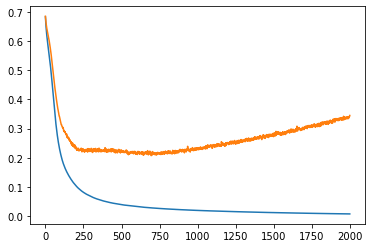

In [557]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
plt.plot(t, train_loss)
plt.plot(t, test_loss)
plt.show()